## Sensitivity Analysis for Sumo model
### Steps followed
1. [Import the necessary libraries to the notebook](#Import_library)
2. [Initialize and load the Sumo model by providing the path and license file](#Initialize)
3. [Define and setup the input factors](#setup)
4. [Conduct the sensitivity analysis](#sensitivity)
5. [Post processing and screening of influential factors](#postprocess)

### <a id=import_library></a> Import libraries

In [2]:
from dynamita.sumo import *
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import stats   

In [169]:
from SALib.sample import morris
from SALib.analyze import morris as mr
import random
import seaborn as sns

In [170]:
%matplotlib inline

### <a id=Initialize></a> Initialize and load the Sumo model

In [97]:
#Provide the installation path and the license file
sumo = Sumo(sumoPath="C:/Users/zerualem/AppData/Local/Dynamita/Sumo16", licenseFile=r"networklicense.sumolic")

License OK...


In [375]:
# Define data communication interval
def datacomm_callback(sumo):
    t.append(sumo.core.csumo_var_get_time_double(sumo.handle))
    #snhx.append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, snhx_pos, 0))
    for i in range(6):
        snhx[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, snhx_pos, i))
        sno2[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, sno2_pos, i))
        sno3[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, sno3_pos, i))
        #KNHx_AOB2[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, KNHx_AOB_pos2, i))
    
    #KNHx_AOB.append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, KNHx_AOB_pos, 0))
    return 0

In [374]:
# Define function to load the model
def loadModel():
    sumo.unload_model()
    if not sumo.load_model('GSBR011518.sumo'):
        print ('Model successfuly loaded!')
        sumo.register_datacomm_callback(datacomm_callback)
        sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize.scs;')

In [399]:
loadModel()

Model successfuly loaded!


**Extract the locations of the variables of interest**

In [376]:
def getVars():
    snhx_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNHx')
    sno2_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNO2')
    sno3_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNO3')
    #KNHx_AOB_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Sumo2__KNHx_AOB_AS')
    #KNHx_AOB_pos2 = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__KNHx_AOB')
    #sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize.scs;')
    print(snhx_pos)
    print(sno2_pos)
    print(sno3_pos)

In [424]:
loadModel()
getVars()

Model successfuly loaded!
86
87
88


### Test run the Sumo model
Test by running the loaded SUMO model for the initial conditions.

In [425]:
%%time 
stop_t=20*24*3600*1000
dataComm = 180000
#sumo.core.csumo_command_send(sumo.handle, b'maptoic;')
sumo.set_stopTime(stop_t)
sumo.set_dataComm(dataComm)
#command = 'set Sumo__Plant__GranularSBR__KNHx_AOB 0.2 0.2 0.2 0.2 0.2 0.2 ;'
#sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))

#sumo.core.csumo_command_send(sumo.handle, b'set Sumo__Plant__GranularSBR__KNHx_AOB 0.2 0.2 0.2 0.2 0.2 0.2;')
sumo.core.csumo_command_send(sumo.handle, b'set Sumo__Plant__Sumo2__KNHx_AOB_AS 0.01;')

t = []
snhx=[[] for i in range(6)]
sno2=[[] for i in range(6)]
sno3=[[] for i in range(6)]
#KNHx_AOB2=[[] for i in range(6)]
#KNHx_AOB=[]
sumo.run_model()

while not sumo.simulation_finished:
        time.sleep(0.01)

Wall time: 13min 13s


In [21]:
titles=["Bulk", "Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5"]
data_dict = dict(zip(titles,snhx))
dframe = pd.DataFrame(data_dict, index=t)

In [ ]:
dframe.head(20)

** <span style="color: firebrick"> Plot the test result </span> **

<IPython.core.display.Javascript object>


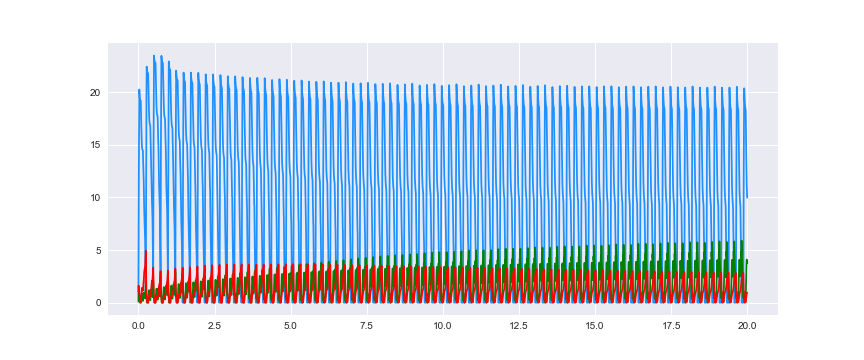

In [429]:
sns.set()
plt.figure(figsize=(12,5))
plt.plot(t,snhx[0], 'dodgerblue', )
plt.plot(t,sno2[0], 'g', )
plt.plot(t,sno3[0], 'r', )

###  <a id=setup></a> Start setting up the sensitivity analysis
#### Start with defining the input factors and their range
21 input factors have been selected to conduct the sensitivity analysis.

In [171]:
%%time
# Start Sensitivity analysis
# Define the model inputs
problem = {
    'num_vars': 23,
    'names': ['KO2_AOB_AS', 'KNHx_AOB_AS', 'muAOB', 'bAOB', 'YAOB', 'KO2_NOB_AS', 'KNO2_NOB_AS', 'muNOB', 'bNOB', 'YNOB', 'KNHx_AMX_AS', 'KNO2_AMX_AS', 'muAMX', 'bAMX', 'YAMX_NO2', 'YAMX_NO3', 'KO2_OHO_AS', 'KNO2_OHO_AS','KNO3_OHO_AS', 'muOHO', 'bOHO', 'YOHO_ox', 'YOHO_anox'],
    'bounds': [[0.1, 3], [0.1, 5], [0.2, 2], [0.01, 0.5], [0.03, 0.3], [0.1, 6], [0.1, 8], [0.1, 5], [0.1, 5], [0.03, 0.3], [0.1, 3], [0.1, 2], [0.01, 0.5], [0.001, 0.05], [0.03, 0.3], [0.03, 0.3], [0.05, 0.5], [0.1, 1], [0.1, 1], [0.1, 8], [0.01, 0.5], [0.1, 0.99],[0.1, 0.99]]
}

# Generate samples
param_values = morris.sample(problem, 30, num_levels=15, grid_jump=3) #optimal_trajectories= 60)

# Si = morris.analyze(problem, X, Y, conf_level=0.95, print_to_console=True, num_levels=4, grid_jump=2)

Wall time: 15 ms


In [ ]:
print(param_values.shape)
params_df=pd.DataFrame(param_values, columns=problem['names'])
params_df.head(10)

### Plot the sample parameters 
The generated samples of the 21 input factors histogram is ploted below. This will help us to visualize how well the samples have been selected from the input space. We should expect approximately a uniform distribution otherwise we have to  re-generate the samples above until we are satisfied.

In [ ]:
#selected_p=random.sample(param_values[:, 0].tolist(),3)
plt.figure(figsize=(16, 32))
cc=('C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C0', 'C1','C2')
for i in range(23):
    plt.subplot(8,3,i+1)
    plt.hist(param_values[:,i], histtype='stepfilled', alpha=0.7, color=cc[i] , bins=10)
    plt.title(problem['names'][i])
    #sns.rugplot(param_values[:,i],lw=2, color='#1C2833')

In [ ]:
param_values[0:5,:]

In [209]:
def converter(x): return ''.join(str(e) for e in 6*list(' '+ str(x)))
print(''.join(str(e) for e in 6*list(' '+ str(6.77))))
    
converter(4.5)
y=''.join(str(e) for e in 6*list(' '+ str(5.4)))
print(y)

 6.77 6.77 6.77 6.77 6.77 6.77
 5.4 5.4 5.4 5.4 5.4 5.4


### <a id=sensitivity></a> Start the sensitivity analysis

** <span style="color:tomato"> The following code section is just for testing some selected scenario </span>**

In [172]:
#load the SUMO model first 
loadModel()
getVars()

Model successfuly loaded!
86
87
88


In [168]:
%%time
# Let's store all the sensitivity analysis results in one data structure.
from collections import OrderedDict
snhx_sensitivity_data = OrderedDict()
sno2_sensitivity_data = OrderedDict()
sno3_sensitivity_data = OrderedDict()
#define and set simulation and data interval times
stop_t=12*3600*1000
dataComm = 180000
sumo.set_stopTime(stop_t)
sumo.set_dataComm(dataComm)

#prepare variables for iteration
t_out=int(stop_t/dataComm)           #Just to make sure that the outputs have the same dimension
#iteration=param_values.shape[0]      #number of iterantion = number of samples generated above 
set_cmd='set Sumo__Plant__Sumo2__'
#param_names=problem['names']

for KO_NOB in [0.01, 0.15, 0.3, 1]:
    command = set_cmd+'KO2_NOB_AS ' + str(KO_NOB) + ';'
                
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    print ('Iteration KO_NOB = ', KO_NOB)
    # Do not forget to empty our lists before a simulation, otherwise
    # new simulation results would just be appended.
    t = []
    snhx=[[] for i in range(6)]
    sno2=[[] for i in range(6)]
    sno3=[[] for i in range(6)]
    
    # Let's have Sumo do some work
    sumo.run_model()
    # The run_model is an asynchronous call, so we need to wait until
    # the current run is finished, otherwise we would mess up our simulations
    while not sumo.simulation_finished:
        time.sleep(0.01)

    # Good, we got our data in the list, let's store 'em in our dictionary, using 
    # KNHx as the label
    print("snhx ", snhx[0][0])
    snhx_sensitivity_data[KO_NOB] = snhx
    sno2_sensitivity_data[KO_NOB] = sno2
    sno3_sensitivity_data[KO_NOB] = sno3

Iteration KO_NOB =  0.01
snhx  1.0000182193689906
Iteration KO_NOB =  0.15
snhx  1.00001822221211
Iteration KO_NOB =  0.3
snhx  1.0000182223816956
Iteration KO_NOB =  1
snhx  1.000018222505327
Wall time: 1min 30s


In [132]:
snhx_pos

86

** <span style="color:dodgerblue"> The following code section is the full simulation for the generated factor samples </span> **

In [ ]:
%%time
# Let's store all the sensitivity analysis results in one data structure.

from collections import OrderedDict
snhx_sensitivity_data = OrderedDict()
sno2_sensitivity_data = OrderedDict()
sno3_sensitivity_data = OrderedDict()

stop_t=12*3600*1000
dataComm = 180000
sumo.set_stopTime(stop_t)
sumo.set_dataComm(dataComm)

t_out=int(stop_t/dataComm)
iteration=param_values.shape[0]
set_cmd='set Sumo__Plant__Sumo2__'
param_names=problem['names']
for i in range(iteration):
    #k=random.randint(0,719)
    command=''
    for j in range(len(param_names)):
        command +=set_cmd + param_names[j] + ' '+ str(param_values[i,j]) + '; \n'
                
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    print ('Iteration ', i)
    # Do not forget to empty our lists before a simulation, otherwise
    # new simulation results would just be appended.
    t = []
    snhx=[[] for n in range(6)]
    sno2=[[] for n in range(6)]
    sno3=[[] for n in range(6)]
    
    # Let's have Sumo do some work
    sumo.run_model()
    # The run_model is an asynchronous call, so we need to wait until
    # the current run is finished, otherwise we would mess up our simulations
    while not sumo.simulation_finished:
        time.sleep(0.01)

    # Good, we got our data in the list, let's store 'em in our dictionary, using 
    # KNHx as the label
    
    snhx_sensitivity_data[i] = snhx
    sno2_sensitivity_data[i] = sno2
    sno3_sensitivity_data[i] = sno3

In [31]:
len(sno2_sensitivity_data.keys())

15

In [183]:
#Put the dictionary into a numpy array
from tempfile import TemporaryFile

snhx_sens_list=list(snhx_sensitivity_data.values())
sno2_sens_list=list(sno2_sensitivity_data.values())
sno3_sens_list=list(sno3_sensitivity_data.values())
#print(min(len(x) for x in sens_list))
snhx_sens_array=np.array(snhx_sens_list)
sno2_sens_array=np.array(sno2_sens_list)
sno3_sens_array=np.array(sno3_sens_list)

print ("snhx array dim ", snhx_sens_array.ndim)
print ("sno2 array dim ", sno2_sens_array.ndim)
print ("sno3 array dim ", sno3_sens_array.ndim)
print ("snhx array shape ", snhx_sens_array.shape)
print ("sno2 array shape ", snhx_sens_array.shape)

snhx array dim  3
sno2 array dim  3
sno3 array dim  3
snhx array shape  (720, 6, 241)
sno2 array shape  (720, 6, 241)


In [206]:
print(snhx_sens_array[:,0,:].shape)
cum_col=[sum(snhx_sens_array[i,0,:]) for i in range(720)]

print(cum_col.index(min(cum_col)))
print(0.48*24*stop_t/(12*dataComm))

(720, 241)
6714.43740038
643
230.4


### Plot for a desired residual concentration

(720, 241)
(720, 1)
The loc  83.0


<IPython.core.display.Javascript object>


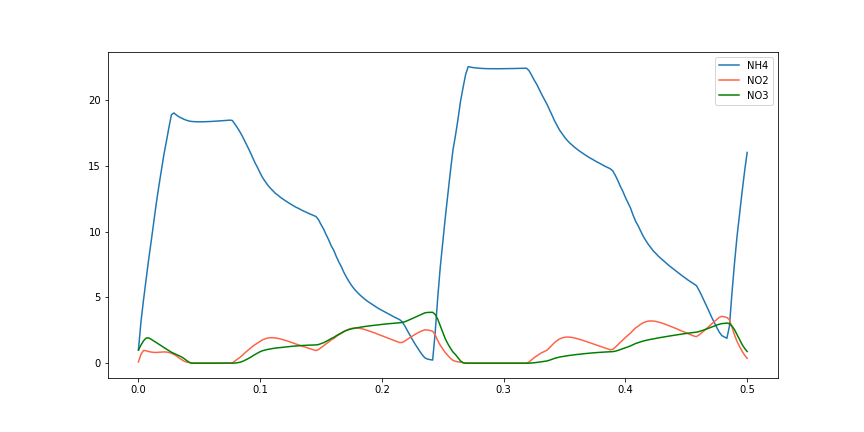

,KO2_AOB_AS,KNHx_AOB_AS,muAOB,bAOB,YAOB,KO2_NOB_AS,KNO2_NOB_AS,muNOB,bNOB,YNOB,...,bAMX,YAMX_NO2,YAMX_NO3,KO2_OHO_AS,KNO2_OHO_AS,KNO3_OHO_AS,muOHO,bOHO,YOHO_ox,YOHO_anox
0,0.721429,2.9,1.357143,0.36,0.145714,5.578571,6.307143,4.65,2.55,0.222857,...,0.0255,0.126429,0.222857,0.307143,0.55,0.807143,7.435714,0.325,0.545,0.672143


In [320]:
tbl=snhx_sens_array[:,0,:]
print(tbl.shape)
id_col=np.arange(720).reshape((720,1))
print(id_col.shape)
tbl=np.concatenate((tbl, id_col), axis=1)
tbl=pd.DataFrame(tbl)

tbl=tbl.sort_values(by=230,ascending=True)
tbl.head()
for i in range(720):
    if tbl.iloc[i,230]>2:
        loc=tbl.iloc[i,241]
        print("The loc ", loc)
        break
selected_params=param_values[int(loc),:].reshape(1,23)

df=pd.DataFrame(selected_params)
df.columns=param_names
fig=plt.figure(figsize=(12,6))
plt.plot(t,snhx_sens_array[int(loc),0,:], label='NH4')
plt.plot(t,sno2_sens_array[int(loc),0,:], 'tomato', label="NO2")
plt.plot(t,sno3_sens_array[int(loc),0,:], 'g', label="NO3")
plt.legend()
df

In [331]:
%%time
# Let's store all the sensitivity analysis results in one data structure.

from collections import OrderedDict
snhx__data = OrderedDict()
sno2__data = OrderedDict()
sno3__data = OrderedDict()

stop_t=20*24*3600*1000
dataComm = 180000
sumo.set_stopTime(stop_t)
sumo.set_dataComm(dataComm)

t_out=int(stop_t/dataComm)
#iteration=param_values.shape[0]
set_cmd='set Sumo__Plant__Sumo2__'
param_names=problem['names']
for i in range(1):
    #k=random.randint(0,719)
    command=''
    for j in range(len(param_names)):
        command +=set_cmd + param_names[j] + ' '+ str(selected_params[i,j]) + '; \n'
                
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    print ('Iteration ', i)
    # Do not forget to empty our lists before a simulation, otherwise
    # new simulation results would just be appended.
    t = []
    snhx=[[] for n in range(6)]
    sno2=[[] for n in range(6)]
    sno3=[[] for n in range(6)]
    
    # Let's have Sumo do some work
    sumo.run_model()
    # The run_model is an asynchronous call, so we need to wait until
    # the current run is finished, otherwise we would mess up our simulations
    while not sumo.simulation_finished:
        time.sleep(0.01)

    # Good, we got our data in the list, let's store 'em in our dictionary, using 
    # KNHx as the label
    
    snhx__data[i] = snhx
    sno2__data[i] = sno2
    sno3__data[i] = sno3

Iteration  0
Wall time: 21min 28s


<IPython.core.display.Javascript object>


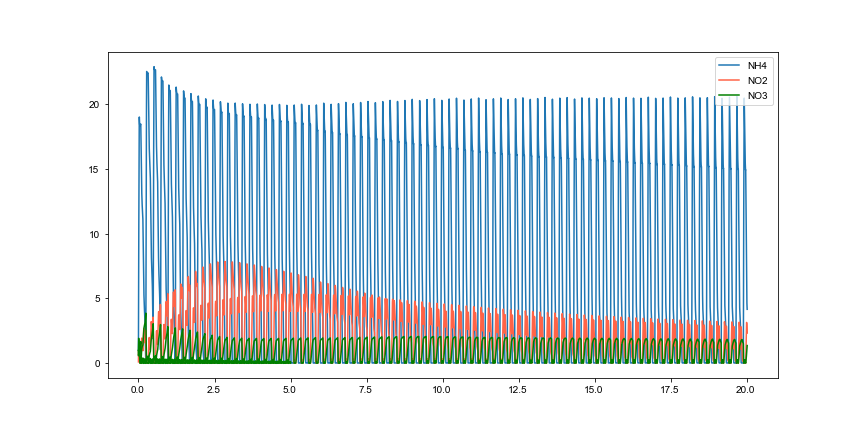

In [332]:
fig=plt.figure(figsize=(12,6))
plt.plot(t,snhx__data[0][0], label='NH4')
plt.plot(t,sno2__data[0][0], 'tomato', label="NO2")
plt.plot(t,sno3__data[0][0], 'g', label="NO3")
plt.legend()

In [ ]:
import plotly
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)

plotly.offline.iplot({
    "data": [Scatter(x=[1, 2, 3, 4], y=[4, 3, 2, 1])],
    "layout": Layout(title="hello world")
})

In [339]:
dims=[dict(range=problem['bounds'][i],values=params_df.iloc[:,i]) for i in range(23)]
type(dims)

list

In [361]:
import plotly
import plotly.graph_objs as go

#df = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/iris.csv")
dims=[dict(range=problem['bounds'][i],values=params_df.iloc[0:720:10,i]) for i in range(23)]

data = [ go.Parcoords(dimensions = dims) ]

layout = go.Layout(
    plot_bgcolor = '#E5E5E5',
    paper_bgcolor = '#E5E5E5'
)

fig = go.Figure(data = data, layout = layout)
plotly.offline.iplot(fig, filename = 'parcoords-basic')

### Save simulation results to a text file

In [175]:
with open('snhx_sens2.txt','wb') as f:
    for a in snhx_sens_array:
        np.savetxt(f, a)
        f.write(b'\n')
        
with open('sno2_sens2.txt','wb') as f:
    for a in sno2_sens_array:
        np.savetxt(f, a)
        f.write(b'\n')
        
with open('sno3_sens2.txt','wb') as f:
    for a in sno3_sens_array:
        np.savetxt(f, a)
        f.write(b'\n')

### Load simulation result from the saved text file

In [10]:
snhx_array=np.loadtxt('snhx_sens.txt')
snhx_array=snhx_array.reshape(720,6,121)

### Plot simulation results

<IPython.core.display.Javascript object>


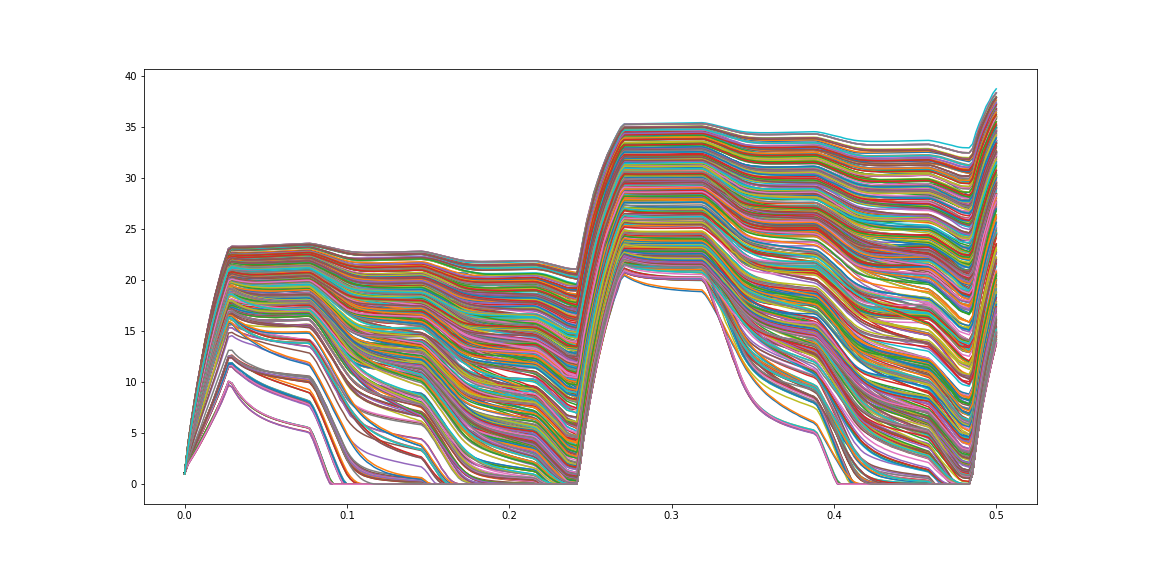

In [205]:
fig1=plt.figure(figsize=(16,8))
for i in range(720):
    plt.plot(t, snhx_sens_array[i,0,:]) #ploting only the bulk layer concentration

<b> Alteratively we can plot the data using the direct simulation results </b>

In [ ]:
%matplotlib notebook
fig,ax=plt.subplots(1,1)
ax.set_xlabel('time')
ax.set_ylabel('SNHx')
titles=("Bulk", "Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5")
markers=('_','x','o','^')
fig.set_size_inches(12,6)
y_list=[]
for k, v in snhx_sensitivity_data.items():
    y=v[0][:len(t)]
    print("y= ",len(y), " t = ", len(t))
    ax.plot(t, y, label=str(k))
    y_list.append(v[0][:121])

plt.legend(loc='upper right', title='Legend')
plt.show()


In [ ]:
#Converting the array to pandas dataframe for the bulk layer
snhx_layer0=snhx_sens_array[:,0,:]
print(snhx_layer0.shape)
snhx_layer0df= pd.DataFrame(snhx_layer0.T)
snhx_layer0df.head(10)

### Ploting results using bokeh library for better visualization

In [ ]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import named
from bokeh.palettes import d3
output_notebook()
clrs=d3['Category20'][20]
i=0
# create a new plot with a title and axis labels
p = figure(plot_width=800, plot_height=400, title="Ammonium concentration", x_axis_label='time, day', y_axis_label='mg-N/L')
for k, v in snhx_sensitivity_data.items():
    if i > 19:
        i=0

    p.line(t, v[0], legend=str(k), color=clrs[i], line_width=2 )
    i +=1
# show the results
show(p)

In [ ]:
X=np.array(list(snhx_sensitivity_data.keys()))
Y=np.array(y_list)
corr=[]
#np.corrcoef(X,Y[:,-1])
for i in range(Y.shape[1]):
    corr.append(stats.pearsonr(X,Y[:,i])[0])
    


In [199]:
plt.plot(t, corr, 'ro')
plt.show()

### <span style="color:IndianRed">Start calculating the sensitivity indices</span>

In [184]:
Si=[]
Si_list_dict=[]
X=param_values
Y=snhx_sens_array[:,0,:]
print("X size ", X.shape)
print(Y.shape)
Si_ndarray=np.empty([4,23,241])

X size  (720, 23)
(720, 241)


In [185]:
#Conduct the sensitivty analysis using morris method from SALib.morris package
for i in range(241):
    Y=snhx_sens_array[:,0,i]
    Si_out=mr.analyze(problem, X, Y, conf_level=0.95, print_to_console=False, num_levels=15, grid_jump=3)   
    Si_list_dict.append(Si_out)
    Si_list=list(Si_out.values())
    Si_array=np.array(Si_list)
    Si.append(Si_list)
    Si_ndarray[:,:,i]=Si_array[1:,:,]
    

### Plot the sensitivity indices

<IPython.core.display.Javascript object>


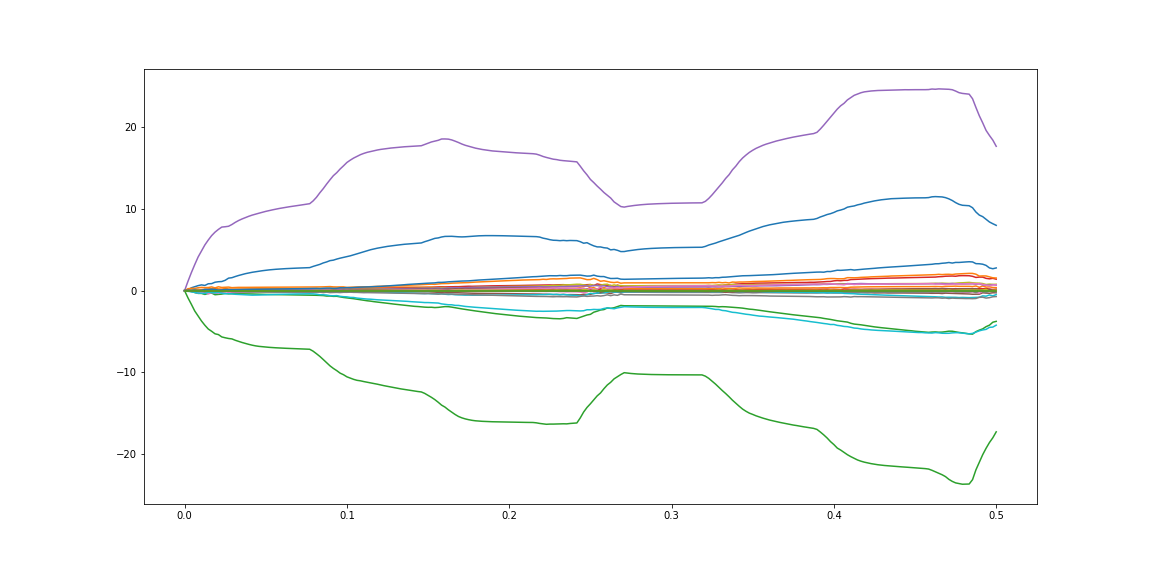

In [186]:
#Plot mu values
fig=plt.figure(figsize=(16,8))
for i in range(23):
    plt.plot(t, Si_ndarray[0,i,:])

### Filter the important parameters based on a threshold

In [188]:
from itertools import compress
sens_treshold=3
sens_filter=[max(Si_ndarray[1,i,:])>sens_treshold for i in range(23)]
#Filter the array
Si_filtered_array=Si_ndarray[1,sens_filter,:]
#Filter the parameters list
filtered_params= list(compress(Si_list[0], sens_filter))

filtered_params

['KO2_AOB_AS', 'muAOB', 'YAOB', 'muAMX', 'muOHO', 'bOHO']

In [189]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import named
from bokeh.palettes import d3
output_notebook()

Loading BokehJS ...

In [190]:
clrs=d3['Category20'][20]
i=0
# create a new plot with a title and axis labels
p = figure(plot_width=800, plot_height=500, title="EE sensitivity indices", x_axis_label='time, day', y_axis_label='EE')
for i in range(sens_filter.count(True)):
    if i > 19:
        i=0
    p.line(t, Si_filtered_array[i,:], legend=filtered_params[i], color=clrs[i], line_width=2 )
    i +=1
# show the results
show(p)

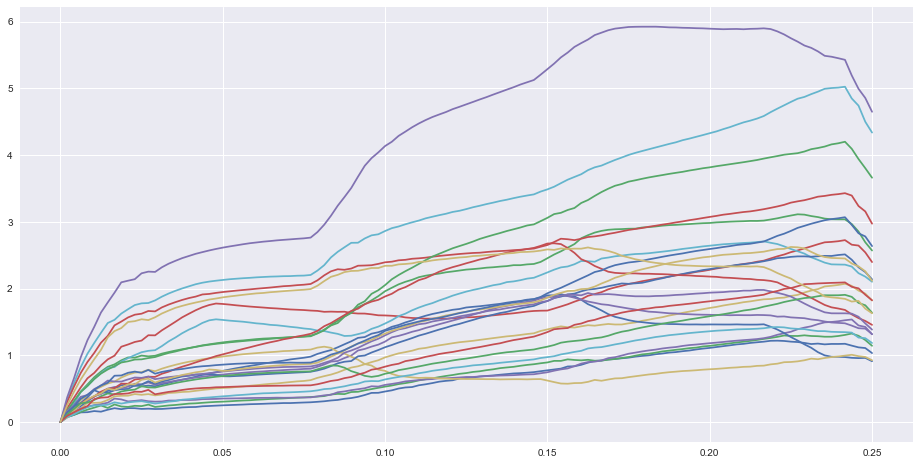

In [65]:
#Plot mu* |mu| values
fig=plt.figure(figsize=(16,8))
for i in range(23):
    plt.plot(t, Si_ndarray[1,i,:])